<a href="https://colab.research.google.com/github/babuus/Machine-Learning/blob/master/CNN/Traffic_Dense_Acc_89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot #For displaying live plots of training

In [ ]:
!wget https://raw.githubusercontent.com/babuus/Datasets/main/trafficnet.rar
!unrar x '/content/trafficnet.rar'

--2021-08-07 06:53:17--  https://raw.githubusercontent.com/babuus/Datasets/main/trafficnet.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23374748 (22M) [application/octet-stream]
Saving to: ‘trafficnet.rar’

trafficnet.rar      100%[===================>]  22.29M  --.-KB/s    in 0.1s    

2021-08-07 06:53:18 (196 MB/s) - ‘trafficnet.rar’ saved [23374748/23374748]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/trafficnet.rar

Creating    trafficnet                                                OK
Creating    trafficnet/dense_traffic                                  OK
Extracting  trafficnet/dense_traffic/images.jpg                            0%  OK 
Extracting  trafficnet/dense_traffic/images_002 

In [ ]:
#Import functions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
%matplotlib inline

import cv2

from livelossplot import PlotLossesKeras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
data_dir = pathlib.Path("/content/trafficnet")
data_dir

PosixPath('/content/trafficnet')

In [ ]:
len(list(data_dir.glob('dense_traffic/*'))), len(list(data_dir.glob('sparse_traffic/*')))

(1100, 1100)

In [ ]:
traffic_dict = {
'dense' : list(data_dir.glob('dense_traffic/*')),
'sparse' : list(data_dir.glob('sparse_traffic/*'))
}

traffic_labels_dict = {
    'dense': 0,
    'sparse': 1,
}

In [ ]:
img = cv2.imread(str(traffic_dict['dense'][3]))
img.shape, cv2.resize(img, (180, 180)).shape

((178, 283, 3), (180, 180, 3))

In [ ]:
X, y = [], []

for traffic_name, images in traffic_dict.items():
    print(traffic_name, ":", len(images))
    for image in images:
        img = cv2.imread(str(image))
        resize_image = cv2.resize(img, (180, 180))
        X.append(resize_image)
        y.append(traffic_labels_dict[traffic_name])

dense : 1100
sparse : 1100


In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([820, 830])), (array([0, 1]), array([280, 270])))

In [ ]:
X_train_scl = X_train / 255
X_test_scl = X_test / 255
len(X_train_scl), len(y_train)

(1650, 1650)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Conv2D(32, 3, padding= 'same', activation='relu'))
model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Conv2D(64, 3, padding= 'same', activation='relu'))
model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics = ['accuracy'])

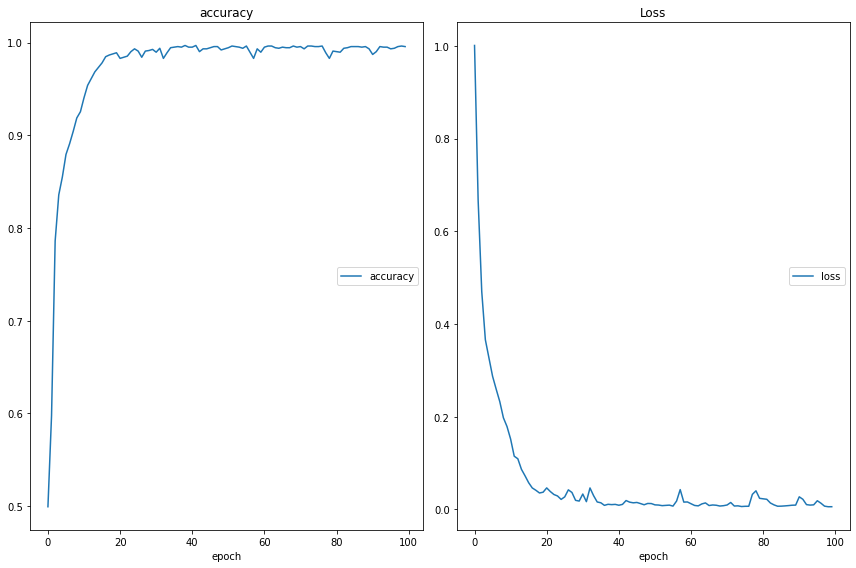

accuracy
	accuracy         	 (min:    0.499, max:    0.997, cur:    0.996)
Loss
	loss             	 (min:    0.006, max:    1.001, cur:    0.006)


In [ ]:
history = model.fit(X_train_scl, y_train, epochs =100, callbacks=[PlotLossesKeras()])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
#ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        # brightness_range=[0.5, 1.5],
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=15,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip=True, 
        vertical_flip=False)
datagen.fit(X_train)

In [ ]:
X_train_scl.shape, y_train.shape, X_test_scl.shape, y_test.shape

((1650, 180, 180, 3), (1650,), (550, 180, 180, 3), (550,))

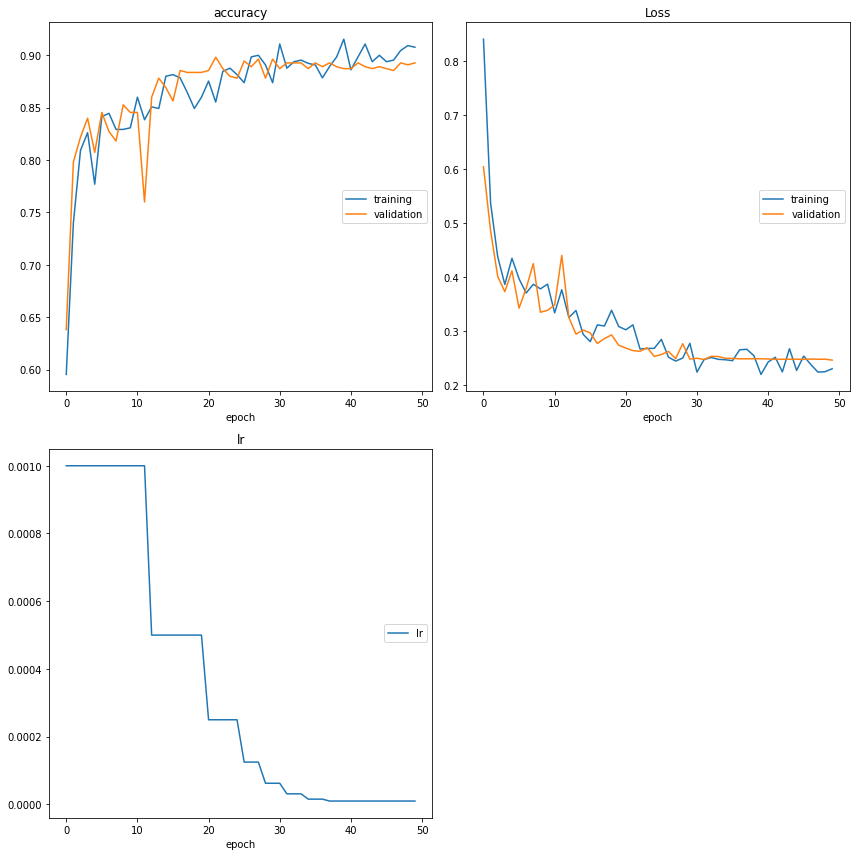

accuracy
	training         	 (min:    0.595, max:    0.915, cur:    0.908)
	validation       	 (min:    0.638, max:    0.898, cur:    0.893)
Loss
	training         	 (min:    0.220, max:    0.841, cur:    0.231)
	validation       	 (min:    0.246, max:    0.604, cur:    0.246)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [ ]:
#With datagen
history = model.fit(datagen.flow(X_train_scl, y_train, batch_size=10),
                  validation_data = (X_test_scl, y_test),
                  steps_per_epoch=np.ceil((len(X_train_scl)*0.8/20)-1),
                  callbacks=[learning_rate_reduction, PlotLossesKeras()],
                  epochs=50)

In [ ]:
model.evaluate(X_test_scl, y_test)

18/18 [==============================] - 0s 9ms/step - loss: 0.2465 - accuracy: 0.8927


[0.24649205803871155, 0.892727255821228]

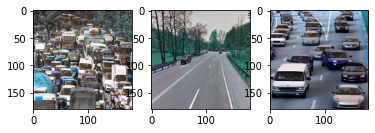

In [ ]:
img = cv2.imread(str('/content/jpg.jfif'))
img1 = cv2.imread('/content/sparse.jpg')
img2 = cv2.imread('/content/lesstraffic.jpg')
resize_image = [cv2.resize(img, (180, 180)),cv2.resize(img1, (180, 180)), cv2.resize(img2, (180, 180))]
fig, ax = plt.subplots(1,3)
ax[0].imshow(resize_image[0])
ax[1].imshow(resize_image[1])
ax[2].imshow(resize_image[2])

In [ ]:
X[0].shape, X.shape

((180, 180, 3), (2200, 180, 180, 3))

In [ ]:
resize_image = np.array(resize_image)

In [ ]:
model.predict(resize_image)

array([[0.],
       [1.],
       [0.]], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /content/drive/MyDrive/Exported-models/Traffic
!mkdir /content/drive/MyDrive/Exported-models/Traffic
model.save('/content/drive/MyDrive/Exported-models/Traffic')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Exported-models/Traffic/assets


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Exported-models/Traffic')
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 16)    448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, None, None, 16)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, None, None, 64)   